<a href="https://colab.research.google.com/github/albim72/DL_11/blob/main/Overfit_and_Underfit_tiny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [4]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-9lktaqs1
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-9lktaqs1
  Resolved https://github.com/tensorflow/docs to commit 60abeb06e500fa5edbbac374fc0d8142c8322aef
  Preparing metadata (setup.py) ... done


In [7]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [8]:
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

In [9]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir,ignore_errors=True)

ZBIÓR DANYCH HIGGSA

In [10]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz','http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 [==============================] - 440s 0us/step


In [12]:
FEATURES = 28

In [13]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1),compression_type="GZIP")

In [14]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [15]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


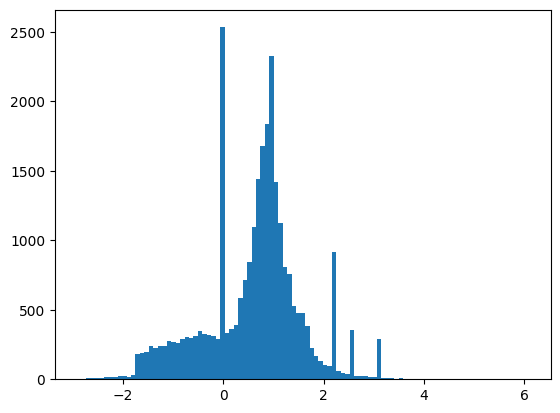

In [16]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [18]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN/BATCH_SIZE

In [19]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [20]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [21]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

PRZYGOTOWANIE MODELU DO PREZENTACJI OVERFITTINGU

In [24]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps = STEPS_PER_EPOCH*1000,
    decay_rate = 1,
    staircase=False
)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

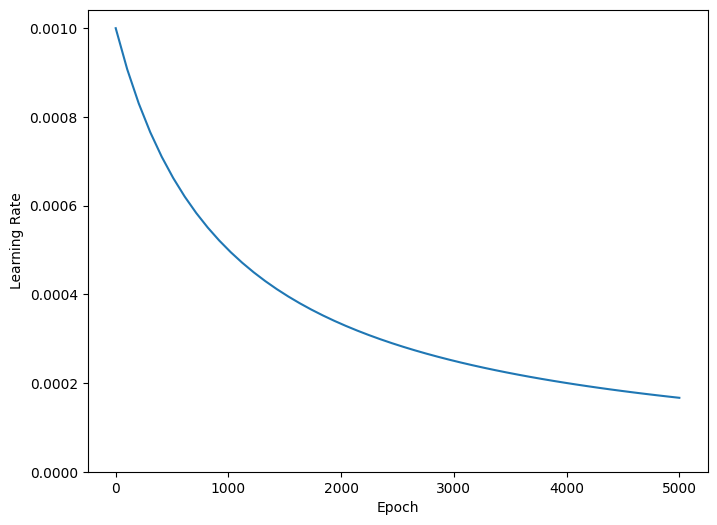

In [26]:
step = np.linspace(0,100_000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH,lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [35]:
def get_callbacks(name):
  return [
      tfdocs.modeling.EpochDots(),
      tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
      tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [41]:
def compile_and_fit(model,name,optimizer=None,max_epochs = 10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer = optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                    tf.keras.losses.BinaryCrossentropy(
                        from_logits=True, name='binary_crossentropy'
                    ),'accuracy'
                ])
  model.summary()
  history = model.fit(
      train_ds,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs = max_epochs,
      validation_data = validate_ds,
      callbacks = get_callbacks(name),
      verbose=0
  )
  return history

BARDZO MAŁY MODEL -> tiny

In [45]:
from keras.src.metrics.confusion_metrics import activations
tiny_model = tf.keras.Sequential([
    layers.Dense(16,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [43]:
size_histories = {}

In [44]:
size_histories['Tiny'] = compile_and_fit(tiny_model,'sizes/Tiny')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481 (1.88 KB)
Trainable params: 481 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.4788,  binary_crossentropy:0.7406,  loss:0.7406,  val_accuracy:0.4870,  val_binary_crossentropy:0.7067,  val_loss:0.7067,  
....................................................................................................
Epoch: 100, accuracy:0.5957,  binary_crossentropy:0.6274,  loss:0.6274,  val_accuracy:0.5820,  val_binary_crossentropy:0.6272,  val_loss:0.6272,  
..........................

In [46]:
print(size_histories)

{'Tiny': <keras.src.callbacks.History object at 0x7a89d8a6c1c0>}


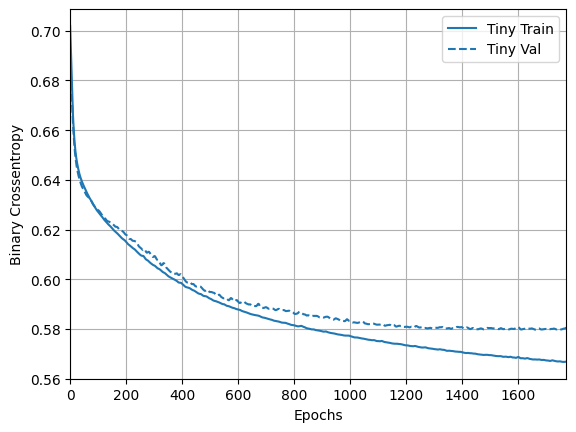

In [47]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy',smoothing_std = 10)
plotter.plot(size_histories)
# plt.ylim([0.5,0.7])